In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from scipy.fft import fft
from scipy.signal import periodogram


%matplotlib qt5 
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})

In [2]:
data_path = "dataset/"
datasets = dict()
# For national_illness OT is Total Patients
for f in ["electricity.csv", "ETTh1.csv", "ETTh2.csv", "ETTm1.csv", "ETTm2.csv", "exchange_rate.csv", "national_illness.csv", "traffic.csv", "weather.csv"]:
# for f in ["exchange_rate.csv"]:
#     print(f.replace(".csv",""))        
    dataset = pd.read_csv(data_path+f)
#     display(dataset.describe())
    datasets[f.replace(".csv","")] = dataset
    print(f.replace(".csv",""), datasets[f.replace(".csv","")].shape)

electricity (26304, 322)
ETTh1 (17420, 8)
ETTh2 (17420, 8)
ETTm1 (69680, 8)
ETTm2 (69680, 8)
exchange_rate (7588, 9)
national_illness (966, 8)
traffic (17544, 863)
weather (52696, 22)


date    datetime64[ns]
HUFL           float64
HULL           float64
MUFL           float64
MULL           float64
LUFL           float64
LULL           float64
OT             float64
dtype: object
(17420, 8)


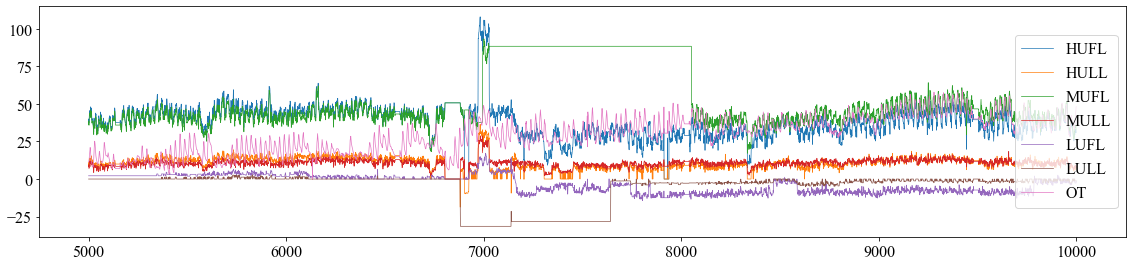

In [3]:
%matplotlib inline
# %matplotlib qt5

dataset_key = "ETTh2"
dset = datasets[dataset_key]
dset.date = pd.to_datetime(dset.date, unit='ns')
print(dset.dtypes)
print(dset.shape )

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

axes = dset.drop("date",axis = 1)[7500-2500:7500+2500].plot(subplots=False, figsize=(16, 4), linewidth=0.7).legend(loc='center right') # , linewidth=1.5
# axes = dset.drop("date",axis = 1)[:].plot(subplots=True, figsize=(10, 20)) # , linewidth=1.5
# axes = axes.flat
# fig = axes[0].get_figure()
# for ax in axes:
#     ax.legend(loc='upper center', bbox_to_anchor=(1, 1.3))


# .legend(bbox_to_anchor=(1.0, 1.0),fontsize='small')
plt.tight_layout()
plt.show()

# dset = datasets["exchange_rate"].loc[:, datasets["exchange_rate"].columns != 'date']

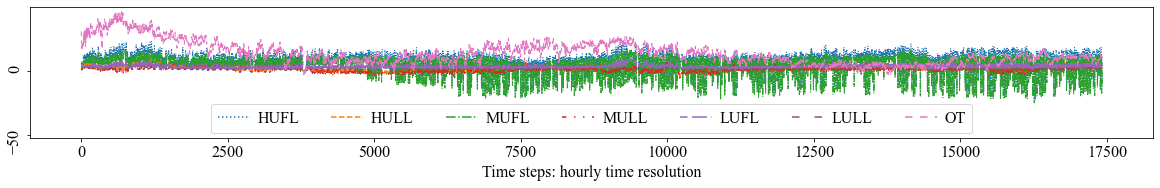

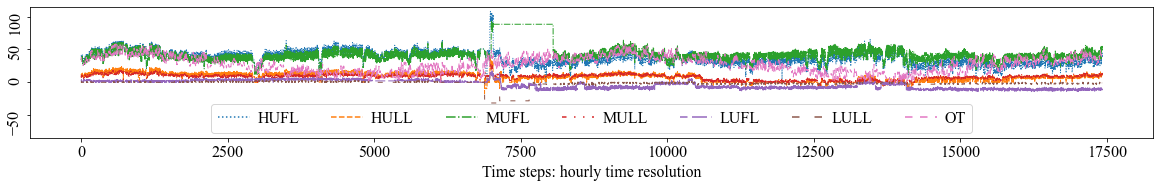

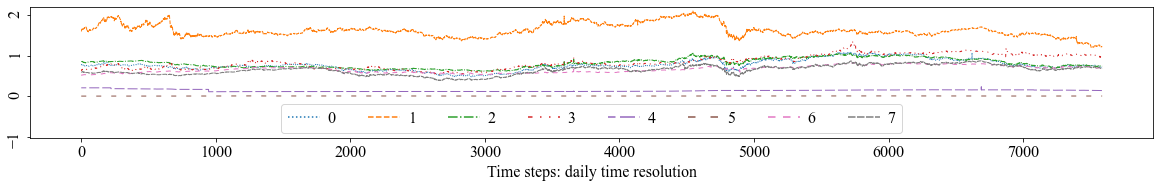

In [4]:
from cycler import cycler

# %matplotlib qt5

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
             cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                               (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

for dataset_key in ["ETTh1", "ETTh2", "exchange_rate"]:
    save = 0
    path = "figures/datasets"
    dset = datasets[dataset_key][:]
    dset.date = pd.to_datetime(dset.date, unit='ns')

    if "ETT" in dataset_key:
        figsize=(16, 2.5)
        mult=0.3
    elif dataset_key=="exchange_rate":  
        figsize=(16, 2.5)
        mult=0.4
    fig = plt.figure(figsize=figsize, constrained_layout=True)

    for feat in dset.drop("date", axis=1).columns:
        plt.plot(dset[feat], linewidth=1.)
    if dataset_key=="ETTh1" or dataset_key=="ETTh2":
        time_res="hourly time resolution"
    elif dataset_key=="exchange_rate":
        time_res="daily time resolution"
    else:
        time_res="unknown"
    plt.xlabel("Time steps: {}".format(time_res))
#     plt.ylim()
    lims = plt.gca().get_ylim()
    plt.gca().set_ylim(lims[0]-(lims[1]-lims[0])*mult,lims[1])
    plt.yticks(rotation='vertical')
    if dataset_key=="exchange_rate":
        legend = plt.legend([str(i) for i in range(len(dset.drop("date",axis = 1).columns))], loc="lower center", ncol = len(dset.drop("date", axis=1).columns), bbox_to_anchor=(0.5, -0.025), handletextpad=0.5, markerscale=10)
    else:
        legend = plt.legend(dset.drop("date", axis=1).columns, loc="lower center", ncol = len(dset.drop("date", axis=1).columns), bbox_to_anchor=(0.5, -0.025), handletextpad=0.5, markerscale=10)
    for leg in legend.legendHandles:
        leg.set_linewidth(1.5)

    if save:
        plt.savefig(path+"\{}_dset_v1.pdf".format(dataset_key), format="pdf", bbox_inches="tight")
    plt.show()

## Looking for periodicities through acf and pacf

https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf#Periodical 

https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb

In [5]:
from cycler import cycler
from matplotlib.lines import Line2D

%matplotlib inline 

# from cycler import cycler
# from matplotlib.colors import TABLEAU_COLORS
# custom_cycler = (cycler(color=[key for key in TABLEAU_COLORS.keys()][:dset_no_date.shape[1]])+
#                  cycler(marker=[key for key in Line2D.markers.keys()][:dset_no_date.shape[1]]))

# plt.rc('axes', prop_cycle=custom_cycler)

data_path = "dataset/"
datasets = dict()
# For national_illness OT is Total Patients
# For ETT, OT is Oil temperature
for f in ["electricity.csv", "ETTh1.csv", "ETTh2.csv", "ETTm1.csv", "ETTm2.csv", "exchange_rate.csv", "national_illness.csv", "traffic.csv", "weather.csv"]:
    dataset = pd.read_csv(data_path+f)
    datasets[f.replace(".csv","")] = dataset
    print(f.replace(".csv",""), datasets[f.replace(".csv","")].shape)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

electricity (26304, 322)
ETTh1 (17420, 8)
ETTh2 (17420, 8)
ETTm1 (69680, 8)
ETTm2 (69680, 8)
exchange_rate (7588, 9)
national_illness (966, 8)
traffic (17544, 863)
weather (52696, 22)


In [8]:
%matplotlib inline 
markers = [key for key in Line2D.markers.keys()]
markers.remove(",")

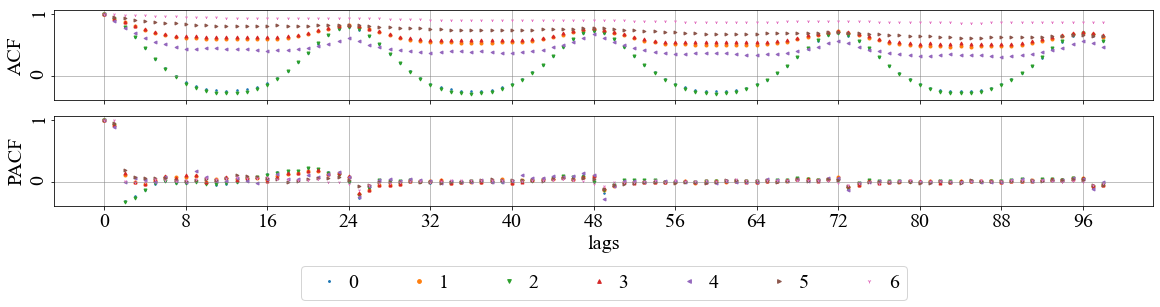

In [9]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})

for dataset_key in ["ETTh1"]:
    dset = datasets[dataset_key]
    dset.date = pd.to_datetime(dset.date, unit='ns')
    path = "figures/datasets"
    dset_no_date = dset.drop("date",axis = 1)

    save = 0
    weeks = 14
    fig, axes = plt.subplots(2, figsize=(16,4), constrained_layout=True, sharex=True)
    lags=weeks*7

    for feat, marker in zip(dset.drop("date",axis = 1).columns, markers):
        plot_acf(dset[feat], use_vlines=False, adjusted=True, zero=True, lags=lags, ax=axes[0], alpha=None, marker=marker, markersize=3)

    axes[0].set_xticks(np.arange(0,lags+1,8)) # x in days
    axes[0].set_title("")
    axes[0].set(ylabel='ACF')
    axes[0].grid(axis='x')
    axes[0].set_ylim(bottom=-0.4)
    axes[0].tick_params(axis='y', rotation=90)
    axes[0].axhline(y = 0, color = 'grey', lw=0.5)
    
    weeks = 14
    lags=weeks*7
    for feat, marker in zip(dset.drop("date",axis = 1).columns, markers):
        plot_pacf(dset[feat], use_vlines=False, zero=True, lags=lags, ax=axes[1], alpha=None, marker=marker, markersize=3)

    axes[1].set_xticks(np.arange(0,lags+1,8)) # x in days
    axes[1].set_title("")
    axes[1].set(ylabel='PACF')
    axes[1].set(xlabel='lags')
    axes[1].grid(axis='x')
    axes[1].set_ylim(bottom=-0.4)
    axes[1].tick_params(axis='y', rotation=90)
    axes[1].axhline(y = 0, color = 'grey', lw=0.5)
#     axes[1].axvline(x = 96, color = 'black', label = 'axvline - full height', lw=1)
    plt.legend([str(i) for i in range(len(dset.drop("date",axis = 1).columns))], loc="lower center", ncol = len(dset.drop("date",axis = 1).columns), bbox_to_anchor=(0, -1.15, 1, 4), handletextpad=0, markerscale=1.25)
    
    if save:
        plt.savefig(path+"\{}_acf_pacf.pdf".format(dataset_key), format="pdf", bbox_inches="tight")
    
    plt.show()


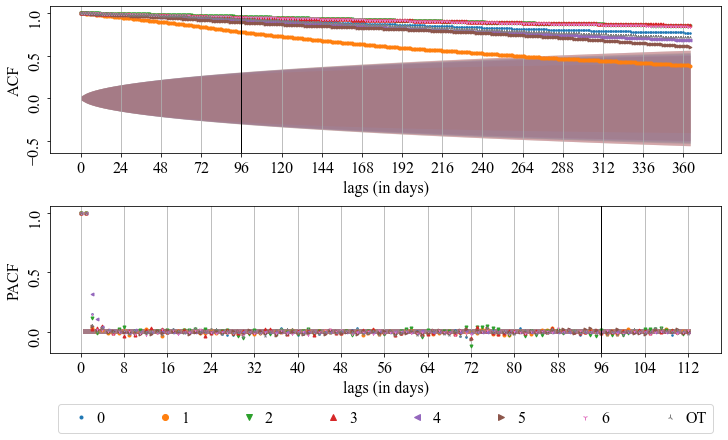

In [10]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

for dataset_key in ["exchange_rate"]:
    dset = datasets[dataset_key]
    dset.date = pd.to_datetime(dset.date, unit='ns')
    path = "figures/datasets"
    dset_no_date = dset.drop("date",axis = 1)

    save = 0
    weeks = 52
    fig, axes = plt.subplots(2, figsize=(10,6), constrained_layout=True)
    lags=weeks*7

    for feat, marker in zip(dset.drop("date",axis = 1).columns, markers):
        plot_acf(dset[feat], use_vlines=False, adjusted=True, zero=True, lags=lags, ax=axes[0], alpha=0.05, marker=marker, markersize=3)

    axes[0].set_xticks(np.arange(0,lags+1,24)) # x in days
    axes[0].set_title("")
    axes[0].set(ylabel='ACF')
    axes[0].set(xlabel='lags (in days)')
    axes[0].grid(axis='x')
    axes[0].tick_params(axis='y', rotation=90)
    axes[0].axvline(x = 96, color = 'black', label = 'axvline - full height', lw=1)
    
    weeks = 16
    lags=weeks*7
    for feat, marker in zip(dset.drop("date",axis = 1).columns, markers):
        plot_pacf(dset[feat], use_vlines=False, zero=True, lags=lags, ax=axes[1], alpha=0.05, marker=marker, markersize=3)

    axes[1].set_xticks(np.arange(0,lags+1,8)) # x in days
    axes[1].set_title("")
    axes[1].set(ylabel='PACF')
    axes[1].set(xlabel='lags (in days)')
    axes[1].grid(axis='x')
    axes[1].tick_params(axis='y', rotation=90)
    plt.legend(dset.drop("date",axis = 1).columns, loc="lower left", mode = "expand", ncol = len(dset.drop("date",axis = 1).columns), bbox_to_anchor=(0, -0.6, 1, 4), handletextpad=0, markerscale=2)
    
    if save:
        plt.savefig(path+"\{}_acf_pacf.pdf".format(dataset_key), format="pdf", bbox_inches="tight")
    
    plt.show()


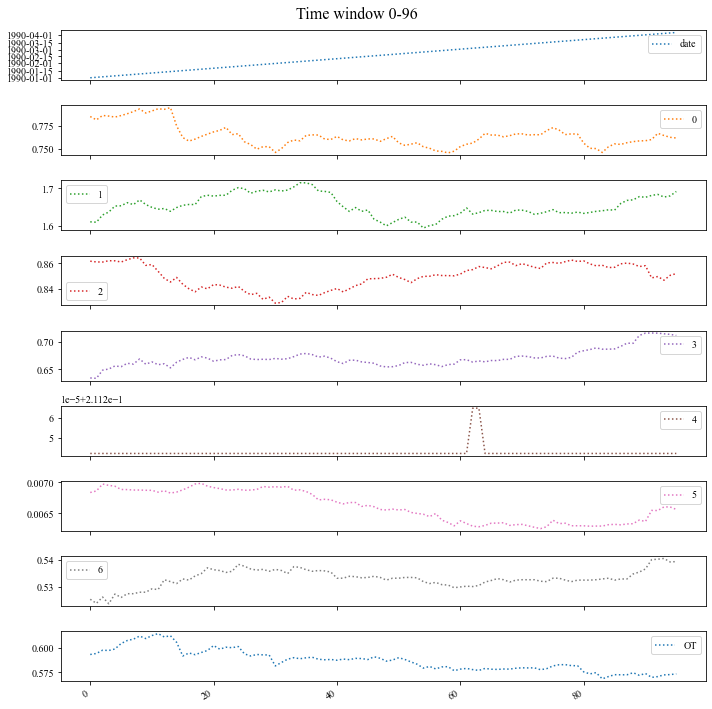

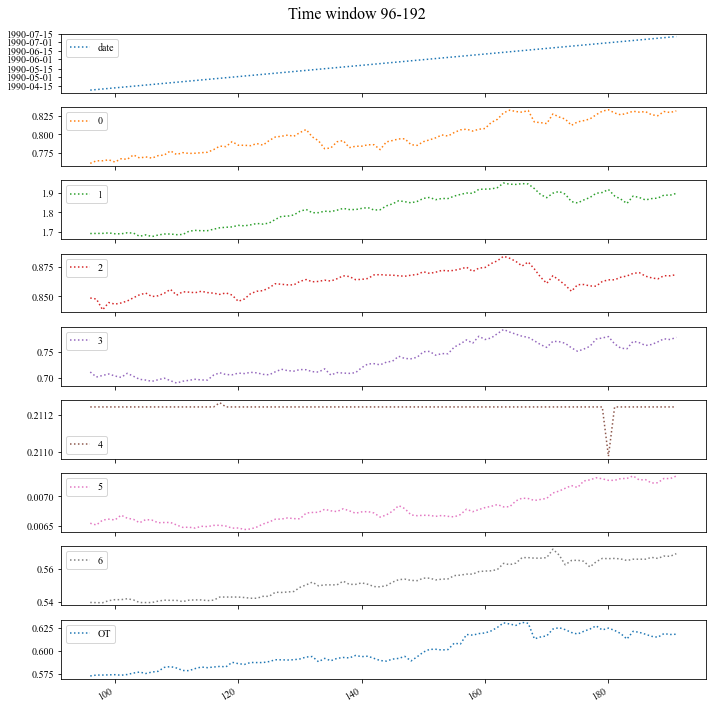

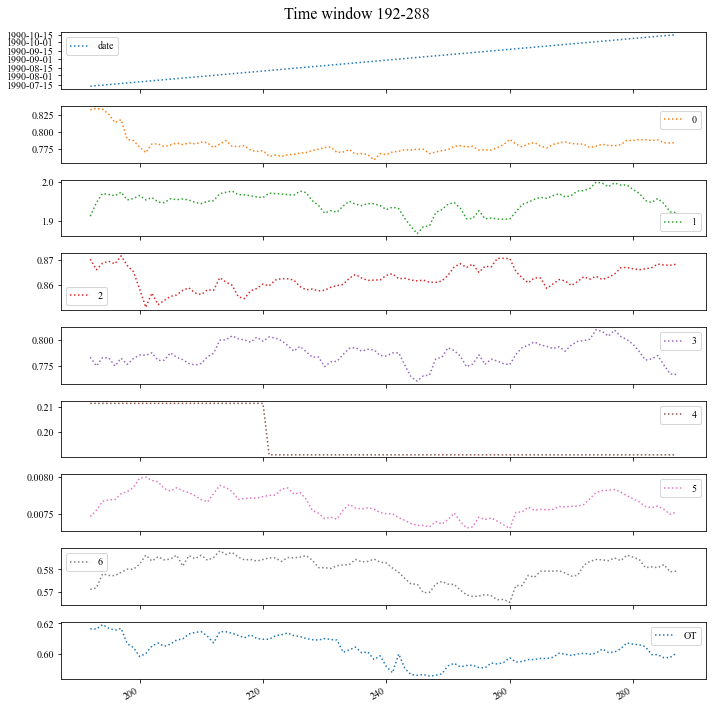

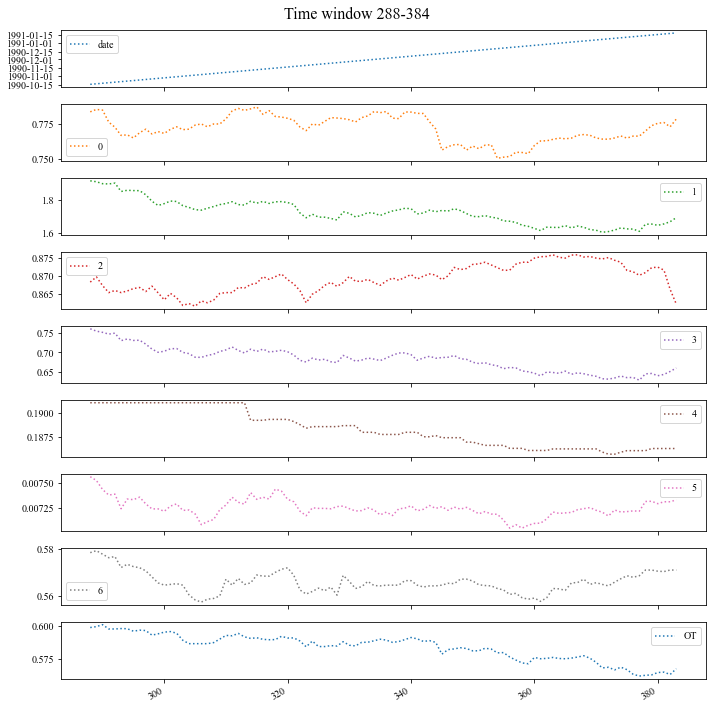

In [12]:
%matplotlib inline
# Checking distribution shifts
dset = datasets["exchange_rate"]
for time in range(4):
    dset[96*time:96*time+96].plot(subplots=True, figsize=(10, 10))
    plt.suptitle("Time window {}-{}".format(time*96,time*96+96), fontsize=16)
    plt.tight_layout()
    plt.show()
    
    
    

In [39]:
# Checking distribution shifts
for time in range(4):
    print("Time window {}-{}".format(time*96,time*96+96))
    display(dset[96*time:96*time+96].describe())

Time window 0-96


,0,1,2,3,4,5,6,OT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.764014,1.653264,0.849990,0.671155,0.211242,0.006613,0.533227,0.586898
std,0.012363,0.029412,0.009808,0.016395,0.000003,0.000253,0.003391,0.011187
min,0.745200,1.594500,0.828638,0.633513,0.211242,0.006254,0.523834,0.568500
25%,0.756250,1.635050,0.841716,0.661222,0.211242,0.006340,0.532021,0.578375
50%,0.761400,1.645500,0.850376,0.668270,0.211242,0.006605,0.533120,0.587300
75%,0.766350,1.679550,0.858664,0.674400,0.211242,0.006878,0.535691,0.593000
max,0.795400,1.715000,0.864304,0.716743,0.211265,0.006987,0.540687,0.614000


Time window 96-192


,0,1,2,3,4,5,6,OT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.798175,1.815077,0.862130,0.735751,0.211239,0.006793,0.552899,0.599673
std,0.022069,0.085285,0.009571,0.030956,0.000027,0.000275,0.010186,0.018237
min,0.760500,1.675000,0.838786,0.690703,0.210975,0.006436,0.539258,0.572500
25%,0.781800,1.729125,0.853825,0.708667,0.211242,0.006598,0.542667,0.585800
50%,0.793900,1.829150,0.863781,0.729264,0.211242,0.006717,0.551876,0.593450
75%,0.819150,1.884175,0.868112,0.765991,0.211242,0.006952,0.563738,0.618350
max,0.833500,1.951500,0.883704,0.793336,0.211265,0.007348,0.572082,0.631300


Time window 192-288


,0,1,2,3,4,5,6,OT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.780160,1.947949,0.862620,0.786948,0.197125,0.007625,0.579889,0.602467
std,0.014041,0.026976,0.004414,0.010767,0.009336,0.000171,0.005699,0.008810
min,0.758100,1.867000,0.851209,0.759878,0.191015,0.007307,0.565611,0.585000
25%,0.772425,1.931750,0.859697,0.780168,0.191015,0.007506,0.577159,0.596450
50%,0.778500,1.951500,0.862367,0.785855,0.191015,0.007605,0.581480,0.601050
75%,0.783350,1.967000,0.866270,0.794818,0.211242,0.007769,0.584283,0.609850
max,0.835100,1.999000,0.871688,0.809913,0.211242,0.007997,0.588062,0.619300


Time window 288-384


,0,1,2,3,4,5,6,OT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.771552,1.722365,0.869251,0.682067,0.188299,0.007248,0.566000,0.583733
std,0.009313,0.076765,0.003893,0.030657,0.001928,0.000090,0.004622,0.010109
min,0.750700,1.601500,0.861475,0.629010,0.185711,0.007047,0.557414,0.561800
25%,0.765000,1.659250,0.866345,0.652423,0.186293,0.007208,0.563341,0.576000
50%,0.772750,1.719000,0.868999,0.685049,0.187966,0.007239,0.565132,0.586500
75%,0.779025,1.770625,0.872239,0.701077,0.191015,0.007289,0.568545,0.590575
max,0.787100,1.915500,0.875810,0.759878,0.191015,0.007560,0.579374,0.601000


# General information and correlation

,date,0,1,2,3,4,5,6,OT
0,1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,0.5930
1,1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,0.5940
2,1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,0.5973
3,1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.523834,0.5970
4,1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.527426,0.5985


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7588 non-null   datetime64[ns]
 1   0       7588 non-null   float64       
 2   1       7588 non-null   float64       
 3   2       7588 non-null   float64       
 4   3       7588 non-null   float64       
 5   4       7588 non-null   float64       
 6   5       7588 non-null   float64       
 7   6       7588 non-null   float64       
 8   OT      7588 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 533.7 KB


None

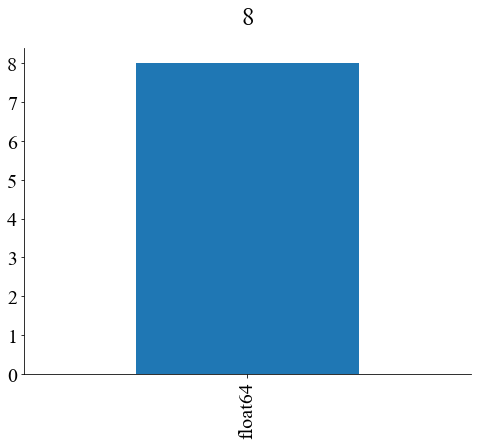

In [13]:
display(dset.head())

display(dset.info())

dset_no_date = dset.drop("date",axis = 1)

plt.figure(figsize = (8,6))
ax = dset_no_date.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 1, height, ha = 'center', size = 25)
sns.despine()


In [14]:
missing = dset.isnull().sum()
missing = missing[missing > 0]
print("Missing values?", len(missing)!=0)
# missing.sort_values(inplace=True)
# missing.plot.bar()

Missing values? False


In [15]:
# "Cardinality" meancategorical_colss the number of unique values in a column
# Categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [colname for colname in dset_no_date.loc[:,:].columns if
                    dset_no_date[colname].nunique() < 8 and 
                    dset_no_date[colname].dtype == "object"]

# All categorical columns
categorical_cols_all = [colname for colname in dset_no_date.loc[:,:].columns if
                    dset_no_date[colname].dtype == "object"]

# Numerical columns
int_cols = [colname for colname in dset_no_date.loc[:,:].columns if 
                dset_no_date[colname].dtype in ['int64']]
float_cols = [colname for colname in dset_no_date.loc[:,:].columns if 
                dset_no_date[colname].dtype in ['float64']]

numerical_cols = int_cols + float_cols

print("Ammount of numerical columns: %s" % len(numerical_cols))
print("\tAmmount of integer columns: {}".format(len(int_cols)))
print("\tAmmount of float columns: {}".format(len(float_cols)))
print("Ammount of categorical columns with less than 8 unique values: %s" % len(categorical_cols))
print("Amount of all categorical columns: %s" % len(categorical_cols_all))

Ammount of numerical columns: 8
	Ammount of integer columns: 0
	Ammount of float columns: 8
Ammount of categorical columns with less than 8 unique values: 0
Amount of all categorical columns: 0


In [16]:
for feat in dset_no_date.columns:
#     print(feat)
    display(dset[feat].describe())

count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: 0, dtype: float64

count    7588.000000
mean        1.634105
std         0.161544
min         1.211534
25%         1.532887
50%         1.606574
75%         1.707646
max         2.109000
Name: 1, dtype: float64

count    7588.000000
mean        0.821811
std         0.117123
min         0.618582
25%         0.727901
50%         0.811583
75%         0.920394
max         1.091524
Name: 2, dtype: float64

count    7588.000000
mean        0.848146
std         0.168874
min         0.548617
25%         0.696864
50%         0.813960
75%         1.014018
max         1.374079
Name: 3, dtype: float64

count    7588.000000
mean        0.142833
std         0.023996
min         0.109292
25%         0.120814
50%         0.145212
75%         0.159948
max         0.237954
Name: 4, dtype: float64

count    7588.000000
mean        0.009343
std         0.001458
min         0.006254
25%         0.008331
50%         0.009151
75%         0.009995
max         0.013202
Name: 5, dtype: float64

count    7588.000000
mean        0.669673
std         0.082836
min         0.523834
25%         0.593287
50%         0.662767
75%         0.731836
max         0.832556
Name: 6, dtype: float64

count    7588.000000
mean        0.654418
std         0.115292
min         0.393153
25%         0.566000
50%         0.669187
75%         0.734901
max         0.882379
Name: OT, dtype: float64

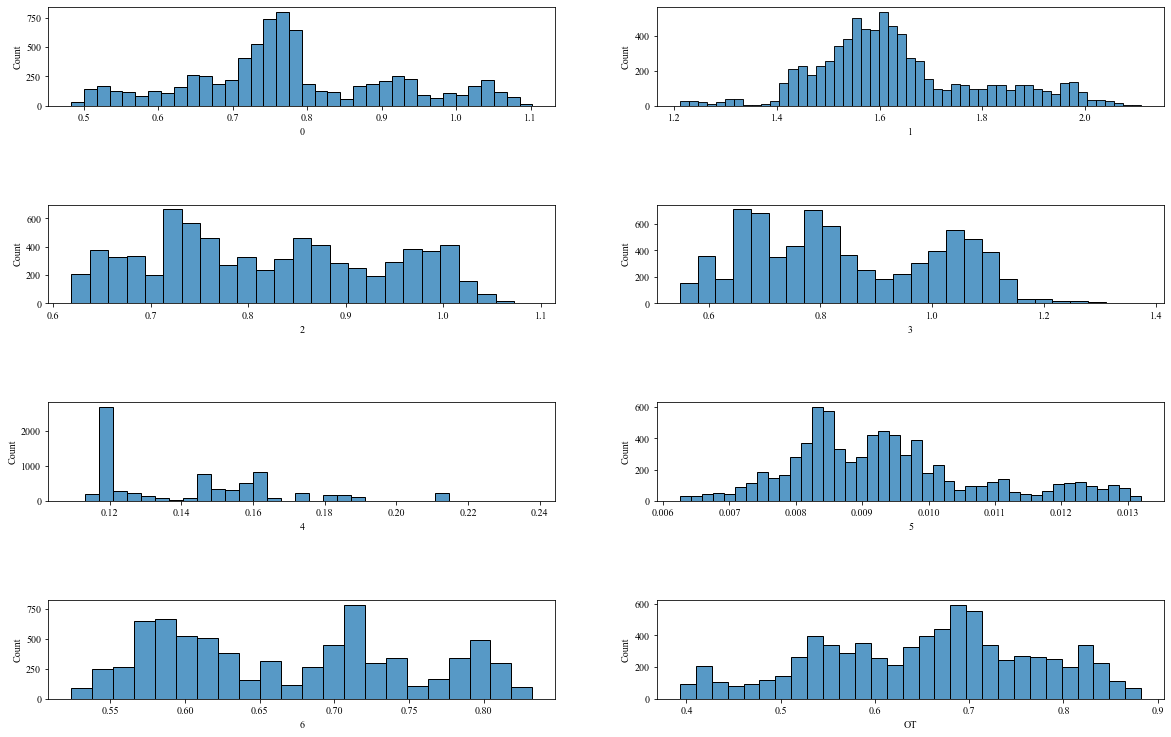

In [17]:
i = 1
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=1)
for feature in float_cols:
    plt.subplot(6,2,i)
    sns.histplot(dset_no_date[feature], palette='Blues_r')
    i = i +1

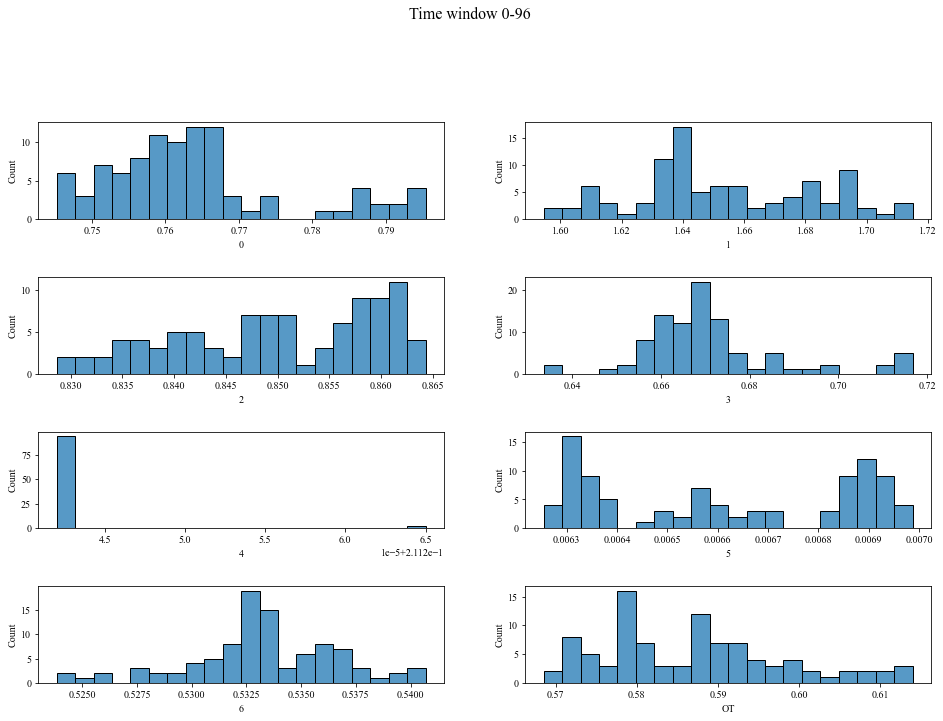

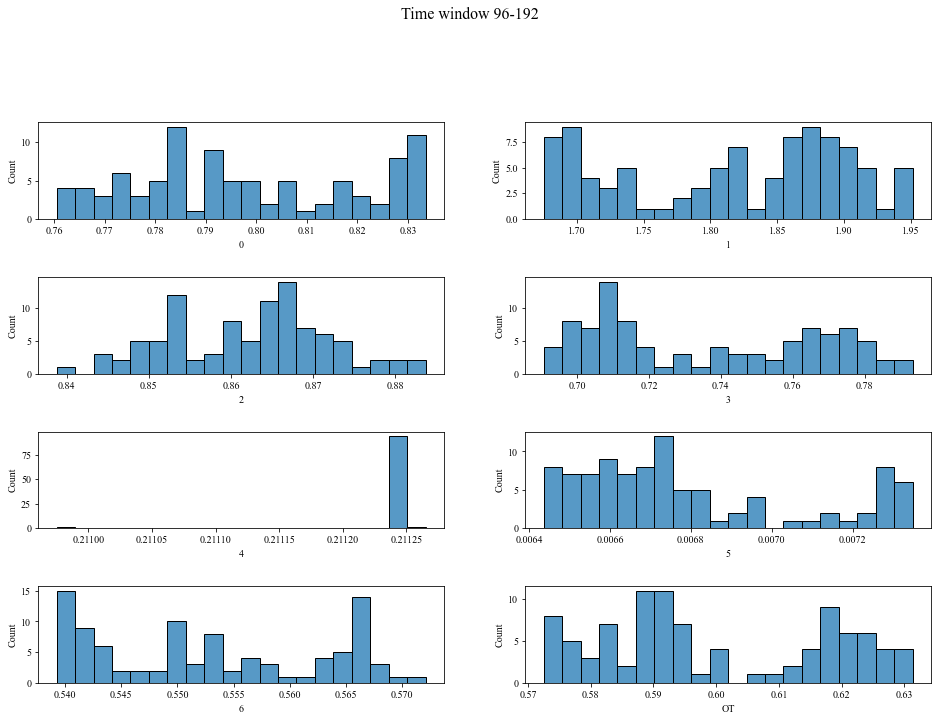

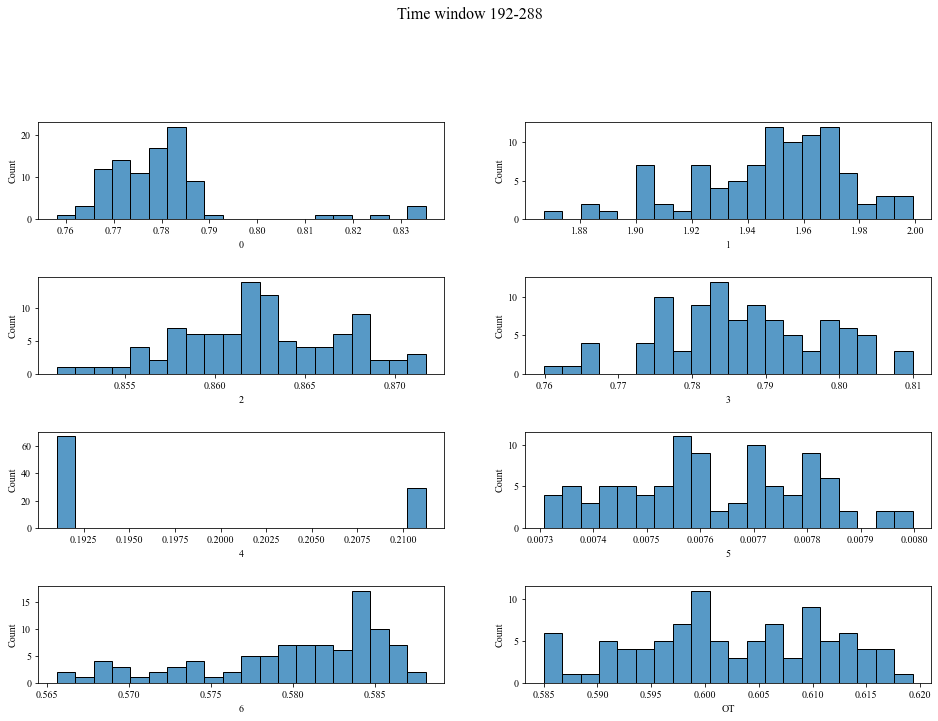

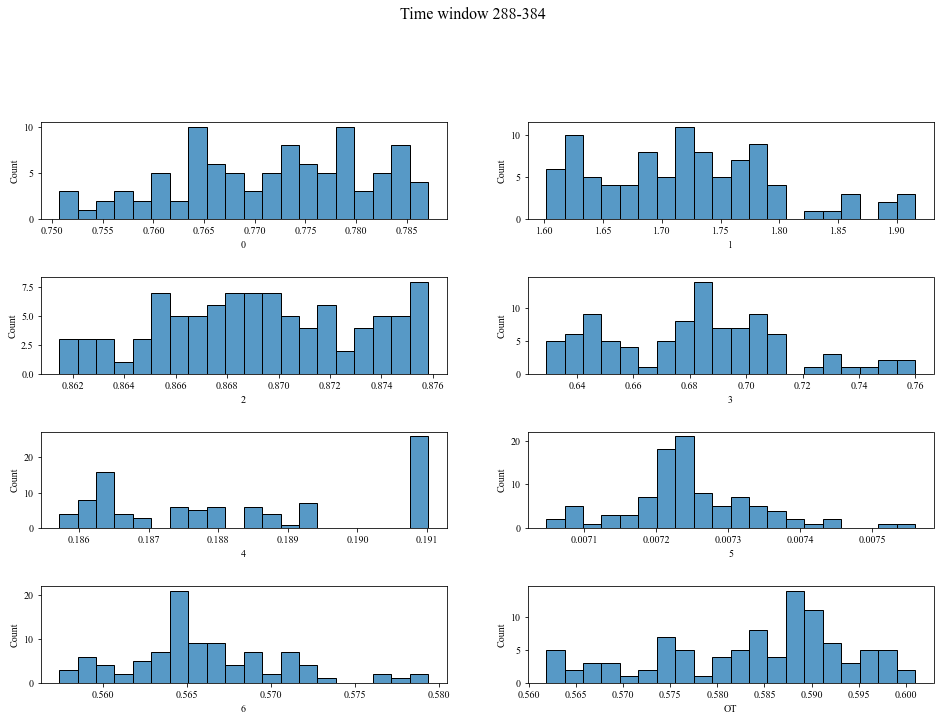

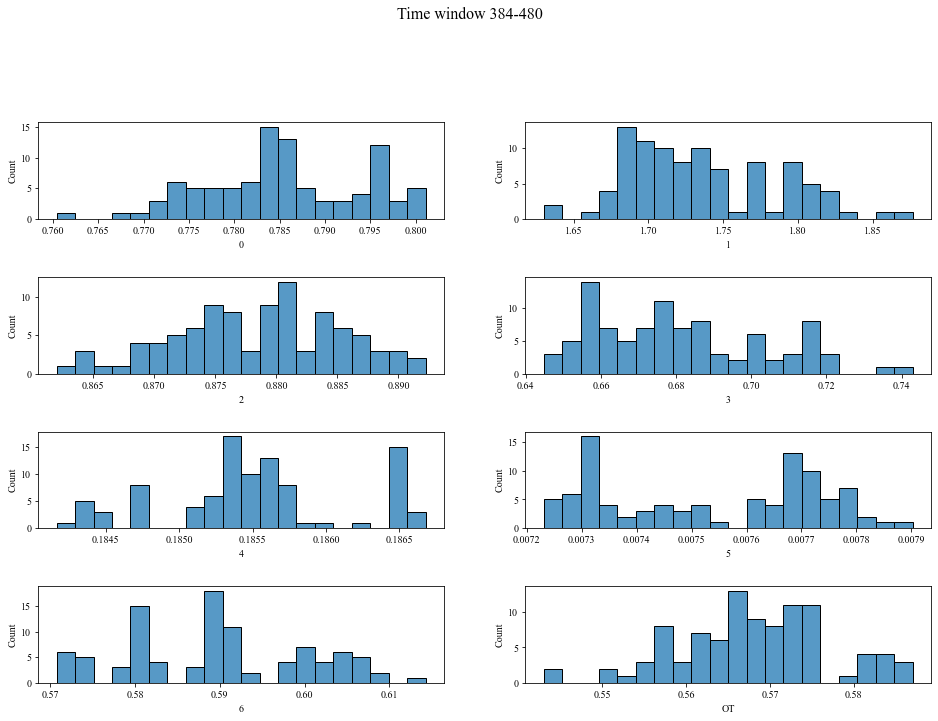

In [19]:
# Checking distribution shifts
# %matplotlib qt5
for time in range(5):
    i = 1
    plt.figure(figsize=(16, 16))
    plt.subplots_adjust(hspace=0.6)
    for feature in float_cols:
        plt.subplot(6,2,i)
        sns.histplot(dset_no_date[feature][time*96:time*96+96], palette='Blues_r', bins=20)
        i = i +1
    plt.suptitle("Time window {}-{}".format(time*96,time*96+96), fontsize=16)
#     plt.tight_layout()
    plt.show()
    
    
    

In [20]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute values
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                colname = corr_matrix.columns[j]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [21]:
# %matplotlib inline
# %matplotlib qt5 

corr = dset_no_date.corr(method='pearson')
display(corr)

# Visualize variables with correlation higher than a threshold

corr_threshold = 0.0

corr_features = correlation(dset_no_date, corr_threshold)
print(corr_features)
print('correlated features above threshold {}: {}'.format(corr_threshold,len(set(corr_features))))

corr_trunq = corr.where(abs(corr) > corr_threshold, np.nan)
display(corr_trunq.style.background_gradient(cmap='viridis',vmin=-1,vmax=1) )



,0,1,2,3,4,5,6,OT
0,1.000000,0.211263,0.913903,0.811949,0.422523,0.661676,0.819556,0.900563
1,0.211263,1.000000,0.346885,-0.054231,0.041920,-0.199195,-0.172660,0.201379
2,0.913903,0.346885,1.000000,0.709560,0.508899,0.552243,0.656708,0.776043
3,0.811949,-0.054231,0.709560,1.000000,0.344609,0.633852,0.907193,0.878720
4,0.422523,0.041920,0.508899,0.344609,1.000000,-0.030113,0.237887,0.255796
5,0.661676,-0.199195,0.552243,0.633852,-0.030113,1.000000,0.708835,0.555616
6,0.819556,-0.172660,0.656708,0.907193,0.237887,0.708835,1.000000,0.851381
OT,0.900563,0.201379,0.776043,0.878720,0.255796,0.555616,0.851381,1.000000


{'2', '0', '3', '4', '1', 'OT', '5', '6'}
correlated features above threshold 0.0: 8


,0,1,2,3,4,5,6,OT
0,1.000000,0.211263,0.913903,0.811949,0.422523,0.661676,0.819556,0.900563
1,0.211263,1.000000,0.346885,-0.054231,0.041920,-0.199195,-0.172660,0.201379
2,0.913903,0.346885,1.000000,0.709560,0.508899,0.552243,0.656708,0.776043
3,0.811949,-0.054231,0.709560,1.000000,0.344609,0.633852,0.907193,0.878720
4,0.422523,0.041920,0.508899,0.344609,1.000000,-0.030113,0.237887,0.255796
5,0.661676,-0.199195,0.552243,0.633852,-0.030113,1.000000,0.708835,0.555616
6,0.819556,-0.172660,0.656708,0.907193,0.237887,0.708835,1.000000,0.851381
OT,0.900563,0.201379,0.776043,0.878720,0.255796,0.555616,0.851381,1.000000


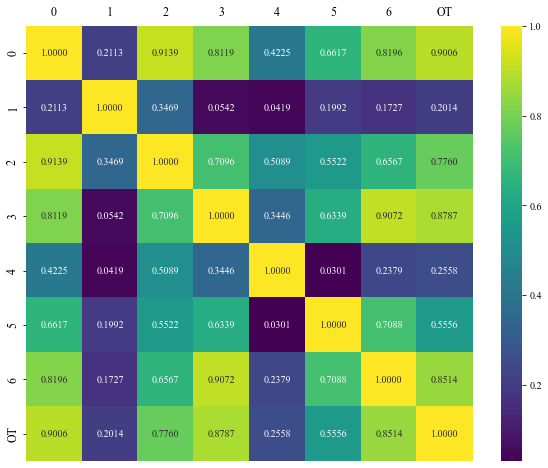

In [26]:
# %matplotlib qt5 

fig = plt.figure(figsize=(10,8))
sns.heatmap(abs(corr), annot = True, fmt = '.4f', cmap="viridis")
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
# plt.xticks(rotation=90)
plt.show()


1 : mean: 1.6341, std: 0.1615, skew: 0.5608


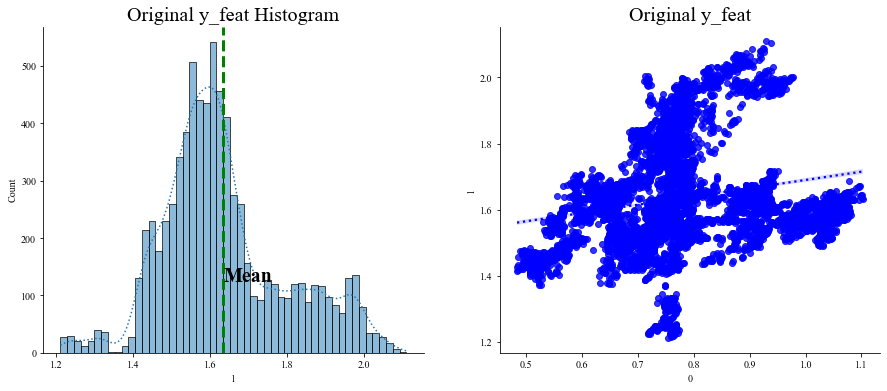

In [27]:
x_feat = "0"
y_feat = "1"

plt.figure(figsize = (15,6))
ax1 = plt.subplot(1,2,1)
sns.histplot(dset_no_date[y_feat],palette='Blues_r',kde=True)
plt.axvline(x=dset_no_date[y_feat].mean(), color='g', linestyle='--', linewidth=3)
plt.text(dset_no_date[y_feat].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black', weight='semibold')
plt.title('Original y_feat Histogram',fontsize=20)
ax2 = plt.subplot(1,2,2)
sns.regplot(data=dset_no_date, y=y_feat, x=x_feat ,ax=ax2,color='Blue')
ax2.set_title('Original y_feat',fontsize=20)
sns.despine()

mean = dset_no_date[y_feat].mean()
std = dset_no_date[y_feat].std()
skew = dset_no_date[y_feat].skew()
print(y_feat,': mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))
plt.show()

# Periodicity

In [28]:
dset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7588 non-null   datetime64[ns]
 1   0       7588 non-null   float64       
 2   1       7588 non-null   float64       
 3   2       7588 non-null   float64       
 4   3       7588 non-null   float64       
 5   4       7588 non-null   float64       
 6   5       7588 non-null   float64       
 7   6       7588 non-null   float64       
 8   OT      7588 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 533.7 KB


In [29]:
display(dset.info())
dset_date_as_index = dset.set_index(dset.date, inplace=False)
display(dset_date_as_index.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7588 non-null   datetime64[ns]
 1   0       7588 non-null   float64       
 2   1       7588 non-null   float64       
 3   2       7588 non-null   float64       
 4   3       7588 non-null   float64       
 5   4       7588 non-null   float64       
 6   5       7588 non-null   float64       
 7   6       7588 non-null   float64       
 8   OT      7588 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 533.7 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7588 non-null   datetime64[ns]
 1   0       7588 non-null   float64       
 2   1       7588 non-null   float64       
 3   2       7588 non-null   float64       
 4   3       7588 non-null   float64       
 5   4       7588 non-null   float64       
 6   5       7588 non-null   float64       
 7   6       7588 non-null   float64       
 8   OT      7588 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 592.8 KB


None

In [30]:
dset.describe()

,0,1,2,3,4,5,6,OT
count,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000
mean,0.776974,1.634105,0.821811,0.848146,0.142833,0.009343,0.669673,0.654418
std,0.136620,0.161544,0.117123,0.168874,0.023996,0.001458,0.082836,0.115292
min,0.483297,1.211534,0.618582,0.548617,0.109292,0.006254,0.523834,0.393153
25%,0.701422,1.532887,0.727901,0.696864,0.120814,0.008331,0.593287,0.566000
50%,0.761377,1.606574,0.811583,0.813960,0.145212,0.009151,0.662767,0.669187
75%,0.873477,1.707646,0.920394,1.014018,0.159948,0.009995,0.731836,0.734901
max,1.102536,2.109000,1.091524,1.374079,0.237954,0.013202,0.832556,0.882379


## Check if series are stationary

https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916

In [31]:
# p-valjue: how likely it is that your data would have occurred under the null hypothesis. If p-value less or equal 
# than 0.05 (95% confidence interval), the result is statistically significant, indicating the evidence is strong 
# enough to reject the null hypothesis in favor of the alternative hypothesis


# ADF: Critical value (test statistic) of the data
# Null hypothesis: there is a unit root, hence non Stationarity exists in the series.
# Alternative Hypothesis: Stationarity exists in the series
# If critical value (test statistic) is lower than t-values, null hypothesis can be rejected, indicating stationarity

def check_stationarity_adf(series):
    result = adfuller(series.values)

    print('\tADF Statistic: %f' % result[0])
    print('\tp-value: %f' % result[1])
    print('\tCritical Values:')
    for key, value in result[4].items():
        print('\t\t%s: %.3f' % (key, value))
        
    if (result[1] < 0.05 and result[0] < result[4]['5%']):
        print("\tWe can reject the null hypothesis: Stationary")
        out = 0

    else:
        print("\tNon-stationary. Null hypothesis cannot be rejected with 95% confidence interval")
        out = 1
    return out

# KPSS: Critical value (test statistic) of the data 
# Null hypothesis: The process is trend stationary
# Alternative Hypothesis: The series has a unit root (series is not stationary)
# If critical value (test statistic) is greater than t-values, null hypothesis can be rejected, indicating non-stationarity

def check_stationarity_kpss(series):
    result = kpss(series.values, nlags="auto")

    print('\tKPSS Statistic: %f' % result[0])
    print('\tp-value: %f' % result[1])
    print('\tCritical Values:')
    for key, value in result[3].items():
        print('\t\t%s: %.3f' % (key, value))
        
    if (result[1] < 0.05 and result[0] > result[3]['5%']):
        print("\tWe can reject the null hypothesis: Non-stationary")
        out = 1

    else:
        print("\tNull hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)")
        out = 0
    return out

# Cases:
#     Case 1: Both tests conclude that the series is not stationary - The series is not stationary
#     Case 2: Both tests conclude that the series is stationary - The series is stationary
#     Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend 
#         needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
#     Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. 
#         Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [32]:
# Case 4 Reject unit root, reject stationarity: both hypotheses are component hypotheses – heteroskedasticity 
# in a series may make a big difference; if there is structural break it will affect inference.

# KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing 
# is to be used to make series stationary. The differenced series is checked for stationarity.

n_stationary_adf = 0
n_stationary_kpss = 0
for feat in dset.drop("date",axis = 1).columns:
    print("Analyzing feature  {}".format(feat))
    n_stationary_adf+=check_stationarity_adf(dset[feat])
    n_stationary_kpss+=check_stationarity_kpss(dset[feat])
    
print("Number of non-stationary series within dataset {} according to ADF: {}".format(dataset_key, n_stationary_adf))
print("Number of non-stationary series within dataset {} according to KPSS: {}".format(dataset_key, n_stationary_kpss))

Analyzing feature  0
	ADF Statistic: -1.664994
	p-value: 0.449233
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 5.291660
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  1


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -2.149718
	p-value: 0.224998
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 1.246762
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  2


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -1.352572
	p-value: 0.604791
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 5.313506
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  3


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -1.586708
	p-value: 0.490267
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 10.535535
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  4


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -2.869174
	p-value: 0.049052
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 2.447505
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  5


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -2.120121
	p-value: 0.236501
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 3.928189
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  6


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -1.747735
	p-value: 0.406701
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 7.978885
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  OT


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


	ADF Statistic: -1.728197
	p-value: 0.416646
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	Non-stationary. Null hypothesis cannot be rejected with 95% confidence interval
	KPSS Statistic: 7.066113
	p-value: 0.010000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Number of non-stationary series within dataset exchange_rate according to ADF: 7
Number of non-stationary series within dataset exchange_rate according to KPSS: 8


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [34]:
# If we apply differencing on the data, both test may imply the differenced dataset is stationary, which indicates it was
# case 4.

n_stationary_adf = 0
n_stationary_kpss = 0
for feat in dset.drop("date",axis = 1).columns:
    print("Analyzing feature  {}".format(feat))
    n_stationary_adf+=check_stationarity_adf((dset[feat]-dset[feat].shift(1)).dropna())
    n_stationary_kpss+=check_stationarity_kpss((dset[feat]-dset[feat].shift(1)).dropna())
    
print("Number of non-stationary series within dataset {} after differencing according to ADF: {}".format(dataset_key, n_stationary_adf))
print("Number of non-stationary series within dataset {} after differencing according to KPSS: {}".format(dataset_key, n_stationary_kpss))


Analyzing feature  0
	ADF Statistic: -99.393431
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.104210
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Analyzing feature  1


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


	ADF Statistic: -22.636334
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.106192
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Analyzing feature  2


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


	ADF Statistic: -35.296871
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.176770
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Analyzing feature  3


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


	ADF Statistic: -24.489297
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.045492
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Analyzing feature  4


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


	ADF Statistic: -47.260145
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.528691
	p-value: 0.035205
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	We can reject the null hypothesis: Non-stationary
Analyzing feature  5
	ADF Statistic: -52.537349
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.158607
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Analyzing feature  6


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


	ADF Statistic: -20.503845
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.195226
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Analyzing feature  OT


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


	ADF Statistic: -52.335680
	p-value: 0.000000
	Critical Values:
		1%: -3.431
		5%: -2.862
		10%: -2.567
	We can reject the null hypothesis: Stationary
	KPSS Statistic: 0.064532
	p-value: 0.100000
	Critical Values:
		10%: 0.347
		5%: 0.463
		2.5%: 0.574
		1%: 0.739
	Null hypothesis cannot be rejected with 95% confidence interval: series is stationary (trend stationary)
Number of non-stationary series within dataset exchange_rate after differencing according to ADF: 0
Number of non-stationary series within dataset exchange_rate after differencing according to KPSS: 1


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


## Looking for periodicities through Fourier transform

https://freedium.cfd/https://medium.com/@shashindra3/three-ways-to-find-the-period-of-a-timeseries-251a6c8c4a3e

https://qingkaikong.blogspot.com/2017/01/signal-processing-finding-periodic.html

In [41]:
dset = datasets["ETTh2"]
for feat in dset.drop(["date"],axis = 1).columns:
    # Calculate the Fourier transform
    yf = np.fft.fft(dset[feat].values)
    xf = np.linspace(0.0, 1.0/(2.0), len(dset[feat].values)//2)

    # Find the dominant frequency
    # We have to drop the first element of the fft as it corresponds to the 
    # DC component or the average value of the signal
    idx = np.argmax(np.abs(yf[1:len(dset[feat].values)//2]))
    freq = xf[idx]

    period =(1/freq)
    print("The peak period of the time series {} with freq = {:.4f} is {} hours = to {:.4f} days = {:.4f} months".format(feat, freq, period, period/24, period/24/30))
    

The peak period of the time series HUFL with freq = 0.0000 is inf hours = to inf days = inf months
The peak period of the time series HULL with freq = 0.0000 is inf hours = to inf days = inf months
The peak period of the time series MUFL with freq = 0.0001 is 8709.0 hours = to 362.8750 days = 12.0958 months
The peak period of the time series MULL with freq = 0.0000 is inf hours = to inf days = inf months
The peak period of the time series LUFL with freq = 0.0000 is inf hours = to inf days = inf months
The peak period of the time series LULL with freq = 0.0001 is 17418.0 hours = to 725.7500 days = 24.1917 months
The peak period of the time series OT with freq = 0.0001 is 17418.0 hours = to 725.7500 days = 24.1917 months


C:\Users\Alberto\anaconda3\envs\LTSF_Linear_gpu_XAI\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


The period of the time series is 17420.0


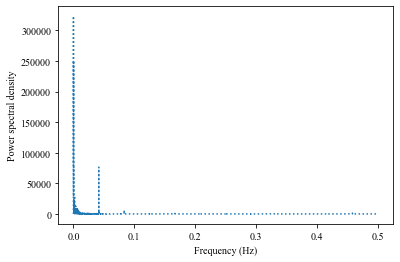

In [42]:
%matplotlib inline 

freq, power = periodogram(dset.HUFL)
period = 1/freq[np.argmax(power)]
print(f"The period of the time series is {period}")

plt.plot(freq, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.show()

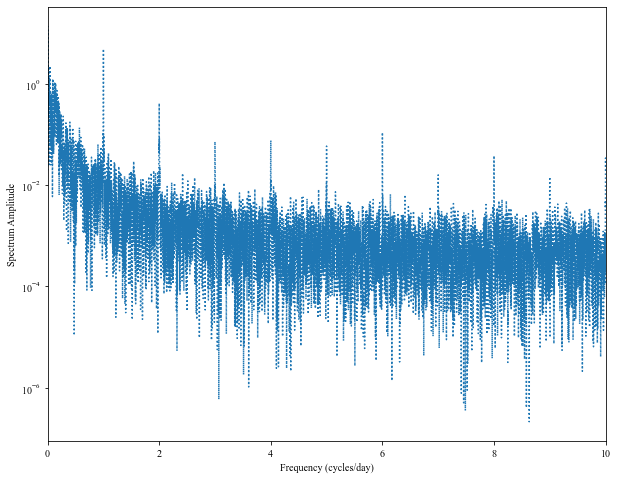

145.16666666666666
181.45833333333331
362.91666666666663
120.9722222222222
0.9997704315886133


In [43]:
fs = 24
f, Pxx = signal.periodogram(dset.HUFL.values - np.mean(dset.HUFL.values), fs = fs, window='hanning', scaling='spectrum')
plt.figure(figsize = (10, 8))
plt.plot(f, Pxx)
plt.xlim(0, 10)
plt.yscale('log')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Spectrum Amplitude')
plt.show()


# print the top 6 period in the signal
for amp_arg in np.argsort(np.abs(Pxx))[::-1][1:6]:
    day = 1 / f[amp_arg]
    print(day)

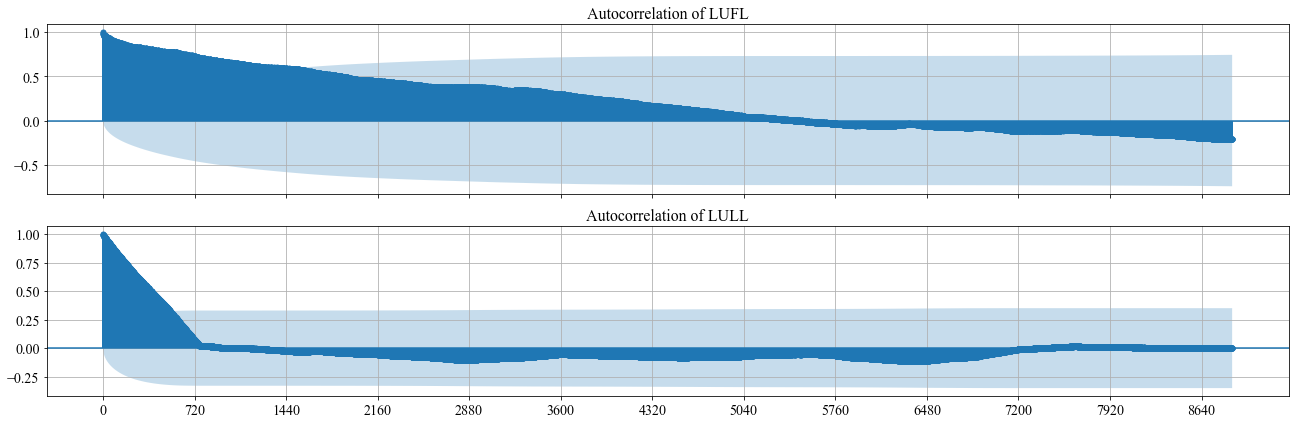

In [44]:
%matplotlib inline

n_feats = dset.drop(["date", "HUFL", "HULL", "MUFL", "MULL", "OT"],axis = 1).columns.size
days = 370
fig, axis = plt.subplots(n_feats, figsize=(18, 3*n_feats), sharex=True)
fig.subplots_adjust(hspace=0.5)

for ax, feat in zip(axis, dset.drop(["date", "HUFL", "HULL", "MUFL", "MULL", "OT"],axis = 1).columns):
    plot_acf(dset[feat], use_vlines=True, adjusted=False, zero=True, lags=24*days, ax=ax, alpha=0.05)
    ax.set_xticks(np.arange(0,24*days+1,24*30))
    ax.tick_params(labelsize=14)
    ax.set_title("Autocorrelation of {}".format(feat), fontsize = 16)
    ax.grid()

plt.tight_layout()
plt.show()